In [1]:
import os
import pandas as pd
import numpy as np
import shutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model



d:\ProgramFiles\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 数据加载函数
def load_and_process_data(lob_path, tape_path):
    # Load LOB data
    Feature_UoB_Set01_LOBs = pd.read_csv(lob_path).dropna()
    Feature_UoB_Set01_LOBs = Feature_UoB_Set01_LOBs.reset_index().drop("index", axis=1)
    
    # Load Tape data
    clean_uob_set01_tapes = pd.read_csv(tape_path)
    
    # Resample and adjust function
    def resample_and_adjust_using_original_times(df, target_count):
        # Assuming 'Time' is in seconds and 'Weighted_Price' is the price
        df['Time_bin'] = (df['Time'] // 10 * 10).astype(int)
        
        # Ensure the range includes 0-10 seconds bin
        all_time_bins = range(0, df['Time_bin'].max() + 10, 10)  # Starts from 0 now
        grouped = df.groupby('Time_bin')
        
        new_records = []
        last_known_price = df['Weighted_Price'].iloc[0]  # Initialize with the first known price
        
        # Iterate through all possible time bins
        for time_bin in all_time_bins:
            if time_bin in grouped.groups:
                group = grouped.get_group(time_bin)
                times = group['Time'].values
                prices = group['Weighted_Price'].values
                if len(prices) > 0:
                    last_known_price = prices[-1]
            else:
                group = None
            
            # If the current time bin is empty or has only one price data point
            if group is None or len(prices) == 0:
                prices = np.full(target_count, last_known_price)
                times = np.linspace(time_bin, time_bin + 9, num=target_count)
            elif len(prices) == 1:
                times = np.linspace(time_bin, time_bin + 9, num=target_count)
                prices = np.full(target_count, last_known_price)
            else:
                # If there are fewer data points than the target count, additional points will be added
                while len(prices) < target_count:
                    time_diffs = np.diff(times)
                    idx_to_fill = np.argmax(time_diffs)
                    new_time = (times[idx_to_fill] + times[idx_to_fill + 1]) / 2
                    new_price = (prices[idx_to_fill] + prices[idx_to_fill + 1]) / 2
                    times = np.insert(times, idx_to_fill + 1, new_time)
                    prices = np.insert(prices, idx_to_fill + 1, new_price)
                # If there are multiple data points within the time bin, proceed with normal processing
                while len(prices) > target_count:
                    time_diffs = np.diff(times)
                    idx_to_merge = np.argmin(time_diffs)
                    new_time = (times[idx_to_merge] + times[idx_to_merge + 1]) / 2
                    new_price = (prices[idx_to_merge] + prices[idx_to_merge + 1]) / 2
                    times = np.delete(times, [idx_to_merge, idx_to_merge + 1])
                    times = np.insert(times, idx_to_merge, new_time)
                    prices = np.delete(prices, [idx_to_merge, idx_to_merge + 1])
                    prices = np.insert(prices, idx_to_merge, new_price)
            # Add the processed data to the results list          
            new_records.extend(zip(times, prices))
    
        new_df = pd.DataFrame(new_records, columns=['Time', 'Weighted_Price'])
        new_df.sort_values('Time', inplace=True)
        return new_df


    # Resample the data
    processed_df = resample_and_adjust_using_original_times(clean_uob_set01_tapes, 6)
    
    
    # Create dataset function
    def create_dataset(data, time_step, step=6):
        X, y = [], []
        for i in range(0, len(data)-time_step, step):
            X.append(data[i:(i+time_step), 0])
            y.append(data[(i+time_step):(i+time_step+6), 0])
        return np.array(X), np.array(y)

    price = processed_df['Weighted_Price'].values.reshape(-1, 1)
    time_step = 360
    _, tags = create_dataset(price, time_step, step=6)

    # 重点重点！！！！！！！！！！Feature scaling不能放在循环里！
    #scaler = MinMaxScaler()
    #features = scaler.fit_transform(Feature_UoB_Set01_LOBs)
    #targets = scaler.fit_transform(tags)
    features = Feature_UoB_Set01_LOBs
    targets = tags

    np.save(lob_path[-18:-4]+'_features.npy', features)
    np.save(tape_path[-19:-4]+'_targets.npy', targets)
    
    return features, targets


In [3]:
def preprocess(directory0, directory1):
    files_lob = os.listdir(directory0)
    files_tape = os.listdir(directory1)
    
    for file_lob, file_tape in zip(files_lob, files_tape):
        file_path0 = os.path.join(directory0, file_lob)
        file_path1 = os.path.join(directory1, file_tape)
        print("Processing: ", file_path0, " and ", file_path1)
        load_and_process_data(file_path0, file_path1)


In [4]:
def move_files(source_dir, lobs_dir, tapes_dir):
    if not os.path.exists(lobs_dir):
        os.makedirs(lobs_dir)
    if not os.path.exists(tapes_dir):
        os.makedirs(tapes_dir)

    # 遍历源目录中的所有文件
    for file in os.listdir(source_dir):
        full_file_path = os.path.join(source_dir, file)
        if os.path.isfile(full_file_path):
            if file.endswith("features.npy"):
                # 移动文件到lobs_dir
                shutil.move(full_file_path, os.path.join(lobs_dir, file))
                print(f"Moved {file} to {lobs_dir}")
            elif file.endswith("targets.npy"):
                # 移动文件到tapes_dir
                shutil.move(full_file_path, os.path.join(tapes_dir, file))
                print(f"Moved {file} to {tapes_dir}")
            else:
                print(f"Skipped {file}, did not match criteria.")
        else:
            print(f"Skipping directory: {file}")


In [ ]:
# train数据集预处理
preprocess("C:\\Users\\zoec0\\Desktop\\DSMP\\data\\train\\lobs", "C:\\Users\\zoec0\\Desktop\\DSMP\\data\\train\\tapes")


source_directory = "C:\\Users\\zoec0\\Desktop\\DSMP\\新建文件夹"
train_lob_dir = "C:\\Users\\zoec0\\Desktop\\DSMP\\新建文件夹\\train\\lobs"
train_tape_dir = "C:\\Users\\zoec0\\Desktop\\DSMP\\新建文件夹\\train\\tapes"

# 移动文件
move_files(source_directory, train_lob_dir, train_tape_dir)

In [10]:
# validate数据集预处理
preprocess("C:\\Users\\zoec0\\Desktop\\DSMP\\data\\validate\\lobs", "C:\\Users\\zoec0\\Desktop\\DSMP\\data\\validate\\tapes")


source_directory = "C:\\Users\\zoec0\\Desktop\\DSMP\\新建文件夹"
validate_lob_dir = "C:\\Users\\zoec0\\Desktop\\DSMP\\新建文件夹\\validate\\lobs"
validate_tape_dir = "C:\\Users\\zoec0\\Desktop\\DSMP\\新建文件夹\\validate\\tapes"

# 移动文件
move_files(source_directory, validate_lob_dir, validate_tape_dir)

Processing:  C:\Users\zoec0\Desktop\DSMP\data\validate\lobs\Featured_Clean_UoB_Set01_2025-04-28LOBs.txt  and  C:\Users\zoec0\Desktop\DSMP\data\validate\tapes\Clean_UoB_Set01_2025-04-28tapes.csv
Processing:  C:\Users\zoec0\Desktop\DSMP\data\validate\lobs\Featured_Clean_UoB_Set01_2025-04-29LOBs.txt  and  C:\Users\zoec0\Desktop\DSMP\data\validate\tapes\Clean_UoB_Set01_2025-04-29tapes.csv
Processing:  C:\Users\zoec0\Desktop\DSMP\data\validate\lobs\Featured_Clean_UoB_Set01_2025-04-30LOBs.txt  and  C:\Users\zoec0\Desktop\DSMP\data\validate\tapes\Clean_UoB_Set01_2025-04-30tapes.csv
Processing:  C:\Users\zoec0\Desktop\DSMP\data\validate\lobs\Featured_Clean_UoB_Set01_2025-05-01LOBs.txt  and  C:\Users\zoec0\Desktop\DSMP\data\validate\tapes\Clean_UoB_Set01_2025-05-01tapes.csv
Processing:  C:\Users\zoec0\Desktop\DSMP\data\validate\lobs\Featured_Clean_UoB_Set01_2025-05-02LOBs.txt  and  C:\Users\zoec0\Desktop\DSMP\data\validate\tapes\Clean_UoB_Set01_2025-05-02tapes.csv
Processing:  C:\Users\zoec0\De

In [11]:
# test数据集预处理
preprocess("C:\\Users\\zoec0\\Desktop\\DSMP\\data\\test\\lobs", "C:\\Users\\zoec0\\Desktop\\DSMP\\data\\test\\tapes")


source_directory = "C:\\Users\\zoec0\\Desktop\\DSMP\\新建文件夹"
test_lob_dir = "C:\\Users\\zoec0\\Desktop\\DSMP\\新建文件夹\\test\\lobs"
test_tape_dir = "C:\\Users\\zoec0\\Desktop\\DSMP\\新建文件夹\\test\\tapes"

# 移动文件
move_files(source_directory, test_lob_dir, test_tape_dir)

Processing:  C:\Users\zoec0\Desktop\DSMP\data\test\lobs\Featured_Clean_UoB_Set01_2025-05-28LOBs.txt  and  C:\Users\zoec0\Desktop\DSMP\data\test\tapes\Clean_UoB_Set01_2025-05-28tapes.csv
Processing:  C:\Users\zoec0\Desktop\DSMP\data\test\lobs\Featured_Clean_UoB_Set01_2025-05-29LOBs.txt  and  C:\Users\zoec0\Desktop\DSMP\data\test\tapes\Clean_UoB_Set01_2025-05-29tapes.csv
Processing:  C:\Users\zoec0\Desktop\DSMP\data\test\lobs\Featured_Clean_UoB_Set01_2025-05-30LOBs.txt  and  C:\Users\zoec0\Desktop\DSMP\data\test\tapes\Clean_UoB_Set01_2025-05-30tapes.csv
Processing:  C:\Users\zoec0\Desktop\DSMP\data\test\lobs\Featured_Clean_UoB_Set01_2025-06-02LOBs.txt  and  C:\Users\zoec0\Desktop\DSMP\data\test\tapes\Clean_UoB_Set01_2025-06-02tapes.csv
Processing:  C:\Users\zoec0\Desktop\DSMP\data\test\lobs\Featured_Clean_UoB_Set01_2025-06-03LOBs.txt  and  C:\Users\zoec0\Desktop\DSMP\data\test\tapes\Clean_UoB_Set01_2025-06-03tapes.csv
Processing:  C:\Users\zoec0\Desktop\DSMP\data\test\lobs\Featured_Clean

In [17]:
# train合并成两个大的dataframe

# 指定文件夹的路径
train_LOBs_path = "train/lobs"
train_Tapes_path = "train/tapes"

# 读取文件夹中所有的.npy文件
files_train_LOBs = [f for f in os.listdir(train_LOBs_path) if f.endswith('.npy')]
files_train_Tapes = [f for f in os.listdir(train_Tapes_path) if f.endswith('.npy')]

# 初始化空的DataFrames
train_LOBs_df = pd.DataFrame()
train_Tapes_df = pd.DataFrame()

# 遍历文件列表，加载每个文件并追加到DataFrame
for file in files_train_LOBs:
    # 加载.npy文件
    data = np.load(os.path.join(train_LOBs_path, file))
    # 将numpy数组转换为DataFrame
    temp_LOBs_df = pd.DataFrame(data)
    # 追加到主DataFrame
    train_LOBs_df = pd.concat([train_LOBs_df, temp_LOBs_df], ignore_index=True)

for file in files_train_Tapes:
    # 加载.npy文件
    data = np.load(os.path.join(train_Tapes_path, file))
    # 将numpy数组转换为DataFrame
    temp_Tapes_df = pd.DataFrame(data)
    # 追加到主DataFrame
    train_Tapes_df = pd.concat([train_Tapes_df, temp_Tapes_df], ignore_index=True)

# 保存成文件
train_LOBs_df.to_csv('train_LOBs_df.csv')
train_Tapes_df.to_csv('train_Tapes_df.csv')


In [18]:
# validate合并成两个大的dataframe

# 指定文件夹的路径
valid_LOBs_path = "validate/lobs"
valid_Tapes_path = "validate/tapes"

# 读取文件夹中所有的.npy文件
files_valid_LOBs = [f for f in os.listdir(valid_LOBs_path) if f.endswith('.npy')]
files_valid_Tapes = [f for f in os.listdir(valid_Tapes_path) if f.endswith('.npy')]

# 初始化空的DataFrames
valid_LOBs_df = pd.DataFrame()
valid_Tapes_df = pd.DataFrame()

# 遍历文件列表，加载每个文件并追加到DataFrame
for file in files_valid_LOBs:
    # 加载.npy文件
    data = np.load(os.path.join(valid_LOBs_path, file))
    # 将numpy数组转换为DataFrame
    temp_LOBs_df = pd.DataFrame(data)
    # 追加到主DataFrame
    valid_LOBs_df = pd.concat([valid_LOBs_df, temp_LOBs_df], ignore_index=True)

for file in files_valid_Tapes:
    # 加载.npy文件
    data = np.load(os.path.join(valid_Tapes_path, file))
    # 将numpy数组转换为DataFrame
    temp_Tapes_df = pd.DataFrame(data)
    # 追加到主DataFrame
    valid_Tapes_df = pd.concat([valid_Tapes_df, temp_Tapes_df], ignore_index=True)

# 保存成文件
valid_LOBs_df.to_csv('valid_LOBs_df.csv')
valid_Tapes_df.to_csv('valid_Tapes_df.csv')


In [19]:
# test合并成两个大的dataframe

# 指定文件夹的路径
test_LOBs_path = "test/lobs"
test_Tapes_path = "test/tapes"

# 读取文件夹中所有的.npy文件
files_test_LOBs = [f for f in os.listdir(test_LOBs_path) if f.endswith('.npy')]
files_test_Tapes = [f for f in os.listdir(test_Tapes_path) if f.endswith('.npy')]

# 初始化空的DataFrames
test_LOBs_df = pd.DataFrame()
test_Tapes_df = pd.DataFrame()

# 遍历文件列表，加载每个文件并追加到DataFrame
for file in files_test_LOBs:
    # 加载.npy文件
    data = np.load(os.path.join(test_LOBs_path, file))
    # 将numpy数组转换为DataFrame
    temp_LOBs_df = pd.DataFrame(data)
    # 追加到主DataFrame
    test_LOBs_df = pd.concat([test_LOBs_df, temp_LOBs_df], ignore_index=True)

for file in files_test_Tapes:
    # 加载.npy文件
    data = np.load(os.path.join(test_Tapes_path, file))
    # 将numpy数组转换为DataFrame
    temp_Tapes_df = pd.DataFrame(data)
    # 追加到主DataFrame
    test_Tapes_df = pd.concat([test_Tapes_df, temp_Tapes_df], ignore_index=True)

# 保存成文件
test_LOBs_df.to_csv('test_LOBs_df.csv')
test_Tapes_df.to_csv('test_Tapes_df.csv')


In [20]:
# 横着合并lobs和tapes
# 此时csv文件未拟合

train_df = pd.concat([train_LOBs_df,train_Tapes_df],axis=1)
train_df.to_csv('train_df.csv')

valid_df = pd.concat([valid_LOBs_df,valid_Tapes_df],axis=1)
valid_df.to_csv('valid_df.csv')

test_df = pd.concat([test_LOBs_df,test_Tapes_df],axis=1)
test_df.to_csv('test_df.csv')

In [21]:
# Feature scaling
scaler = MinMaxScaler()

# fit train
scaler.fit(train_df)

train_df = scaler.transform(train_df)

valid_df = scaler.transform(valid_df)

test_df = scaler.transform(test_df)

In [22]:
# 模型构建
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(248, 1)),
    Dropout(0.2),
    LSTM(30, return_sequences=False),
    Dense(6)  # 输出维度为6
])



d:\ProgramFiles\Anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# 编译优化
model.compile(optimizer='adam', loss='mean_squared_error')


In [27]:
# 分训练集数据
X_train = train_df[:, :248]  # 选择前248列作为X_train

y_train = train_df[:, -6:]   # 选择最后6列作为y_train

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (240000, 248)
y_train shape: (240000, 6)


In [28]:
# 分验证集数据
X_valid = valid_df[:, :248]

y_valid = valid_df[:, -6:]

print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_valid shape: (60000, 248)
y_valid shape: (60000, 6)


In [29]:
# 分测试集数据
X_test = test_df[:, :248]

y_test = test_df[:, -6:]

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (75000, 248)
y_test shape: (75000, 6)


In [44]:
# 初始化用于存储验证损失的列表
val_losses = []

# 创建ModelCheckpoint实例
checkpoint_path = f"checkpoints/model-epoch{{epoch:03d}}-val_loss{{val_loss:.4f}}.keras"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,       # 检查点文件的保存路径
    monitor='val_loss',             # 监控的数据是验证集loss
    save_best_only=False,           # 保存所有模型，不仅仅是最好的模型
    save_weights_only=False,         # 保存完整模型
    mode='auto',
    verbose=1)                      # 打印详细日志

In [45]:
# 模型训练
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_callback]     # 使用checkpoint回调/每次周期保存模型
)

# 提取并存储每个周期的验证损失
val_losses = history.history['val_loss']



Epoch 1/50
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 8.0477e-04
Epoch 1: saving model to checkpoints/model-epoch001-val_loss0.0027.keras
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 1178s 157ms/step - loss: 8.0477e-04 - val_loss: 0.0027
Epoch 2/50
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 7.8690e-04
Epoch 2: saving model to checkpoints/model-epoch002-val_loss0.0008.keras
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 1161s 155ms/step - loss: 7.8690e-04 - val_loss: 7.5285e-04
Epoch 3/50
 972/7500 ━━━━━━━━━━━━━━━━━━━━ 15:14 140ms/step - loss: 5.8894e-04

KeyboardInterrupt: 

In [46]:
# 在所有训练完成后，将val_loss保存到CSV文件
val_loss_df = pd.DataFrame(val_losses, columns=['val_loss'])
val_loss_df.to_csv('validation_losses.csv', index_label='epoch')
print(f"Validation losses saved.")

Validation losses saved.


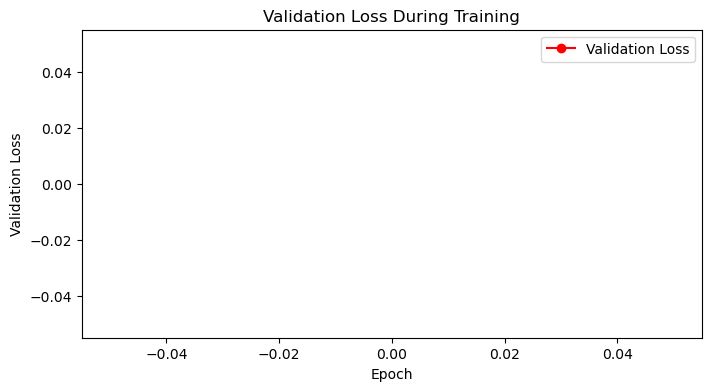

In [48]:
# 可视化val_loss，选出最好的模型

val_loss_df = pd.read_csv('validation_losses.csv')

epochs = val_loss_df.index  

val_loss = val_loss_df['val_loss']

# 创建图表
plt.figure(figsize=(10, 5))

# 绘制验证损失
plt.plot(epochs, val_loss, label='Validation Loss', color='blue', marker='o')

# 添加标题和图例
plt.title('Validation Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

# 显示图表
plt.show()




In [49]:
# 加载最优模型
model_path = 'checkpoints/model-epoch001-val_loss0.0017.keras'
model = load_model(model_path)


In [ ]:
# 新数据点预测
y_pred = model.predict(X_test)


#y_pred_rescaled = scaler.inverse_transform(y_pred)

print("Predicted Values:", y_pred)

In [56]:
# 新数据点预测
y_pred = model.predict(X_test)



2344/2344 ━━━━━━━━━━━━━━━━━━━━ 178s 76ms/step


In [69]:
# 模型评估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)

Mean Squared Error on Test Set: 0.013841910496593716
Root Mean Squared Error on Test Set: 0.11765164893274431


In [70]:
# 横向合并 X_test和 y_pred（为了之后rescale）
combined_pred = np.hstack((X_test, y_pred))

# rescale
combined_pred_rescaled = scaler.inverse_transform(combined_pred)

# 提取最后6列为rescale后的预测值
y_pred_value = combined_pred_rescaled[:, -6:]

# 将 y_pred_value 转换为 DataFrame 并保存
pd.DataFrame(y_pred_value).to_csv('y_pred_value.csv')

# 打印预测值
print("Predicted Values:", y_pred_value)


Predicted Values: [[143.29596192 143.32365353 143.93025799 142.73193762 143.29468817
  143.21760672]
 [143.61839026 144.27900427 144.66510807 143.54755178 143.60821919
  143.75903641]
 [142.63164446 143.16428943 143.75678436 142.82331914 142.70823339
  142.56768737]
 ...
 [144.62986737 142.51954404 143.21229573 144.58894625 140.66379029
  141.25178362]
 [144.36397463 142.63723174 143.29675095 144.43163872 140.7729291
  141.18327935]
 [144.29348618 142.4959225  143.12013559 144.55688447 140.38722912
  140.89522744]]


In [73]:
# y_true_value 
y_true_value = test_Tapes_df



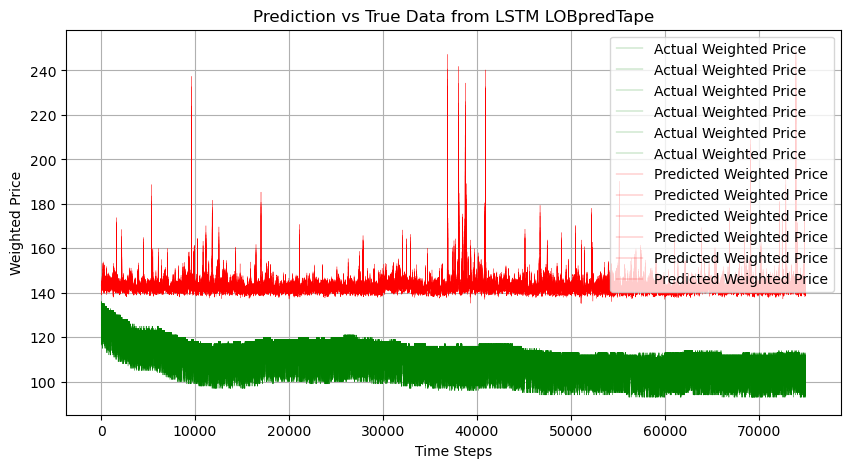

In [74]:
# 可视化预测结果与真实数据
plt.figure(figsize=(10, 5))
plt.plot(y_true_value , label='Actual Weighted Price', color='green', linewidth=0.2)
plt.plot(y_pred_value, label='Predicted Weighted Price', color='red', linewidth=0.2)
plt.title(f'Prediction vs True Data from LSTM LOBpredTape')
plt.xlabel('Time Steps')
plt.ylabel('Weighted Price')
plt.legend()
plt.grid(True)

# 保存图像
plt.savefig('Predicted_vs_Actual_Weighted_Price.png')

plt.show()

